In [1]:
!pip install Librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
path=os.chdir('/content/drive/MyDrive/多媒體程式設計')

Mounted at /content/drive


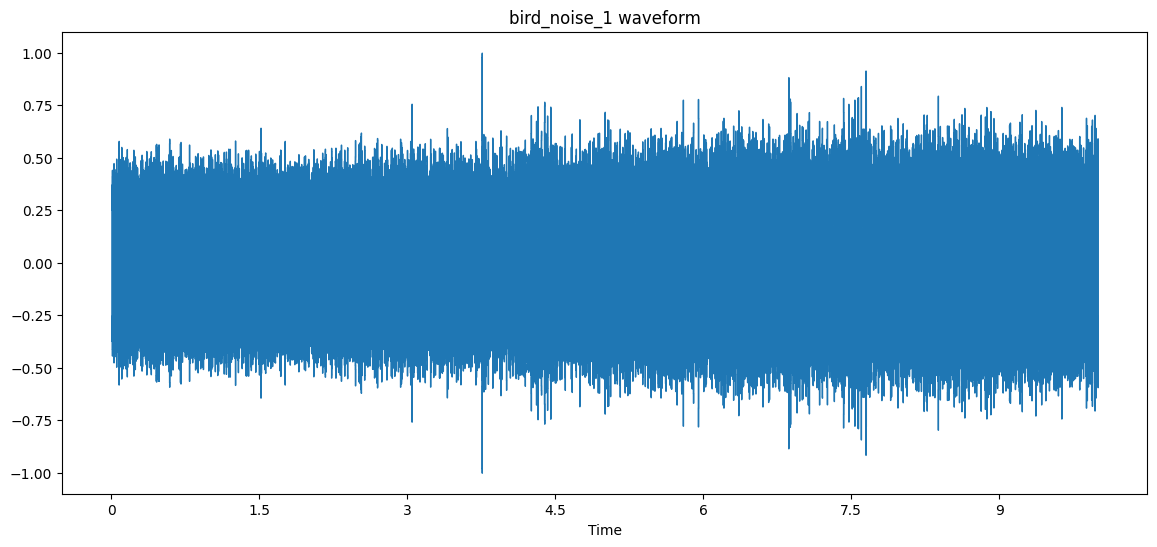

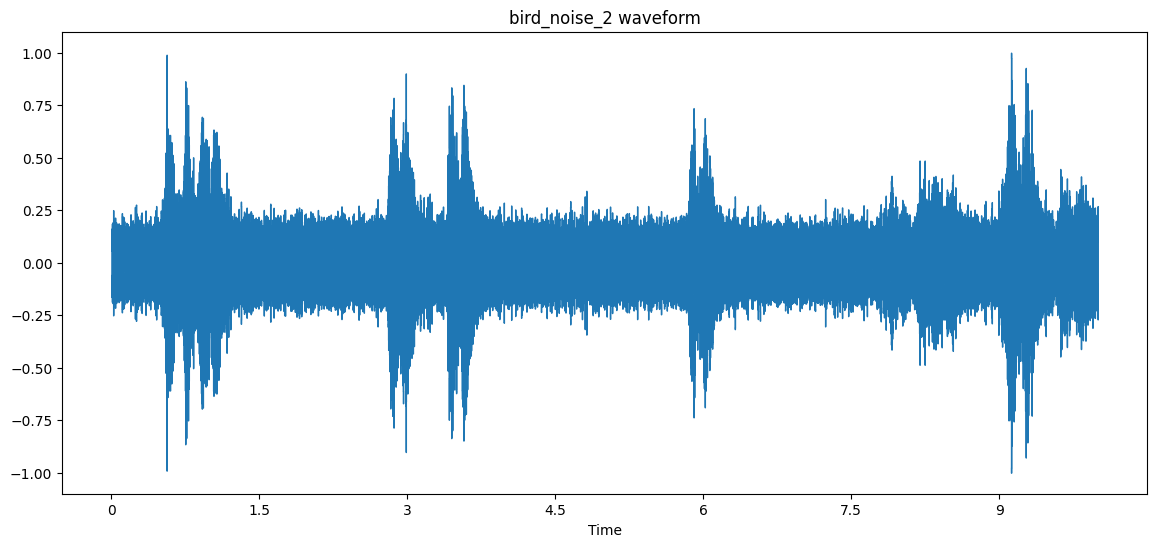

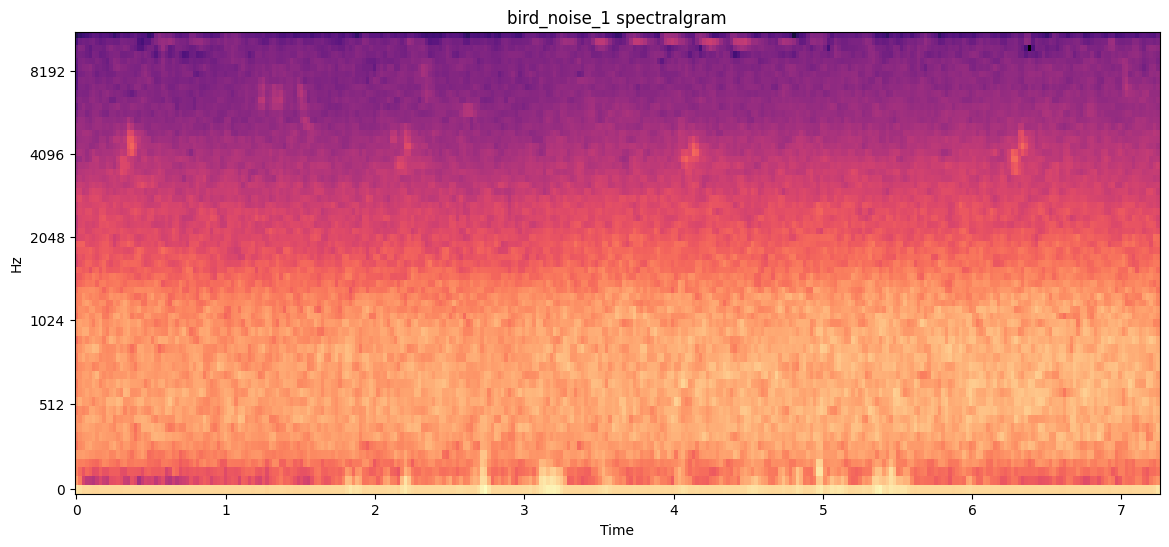

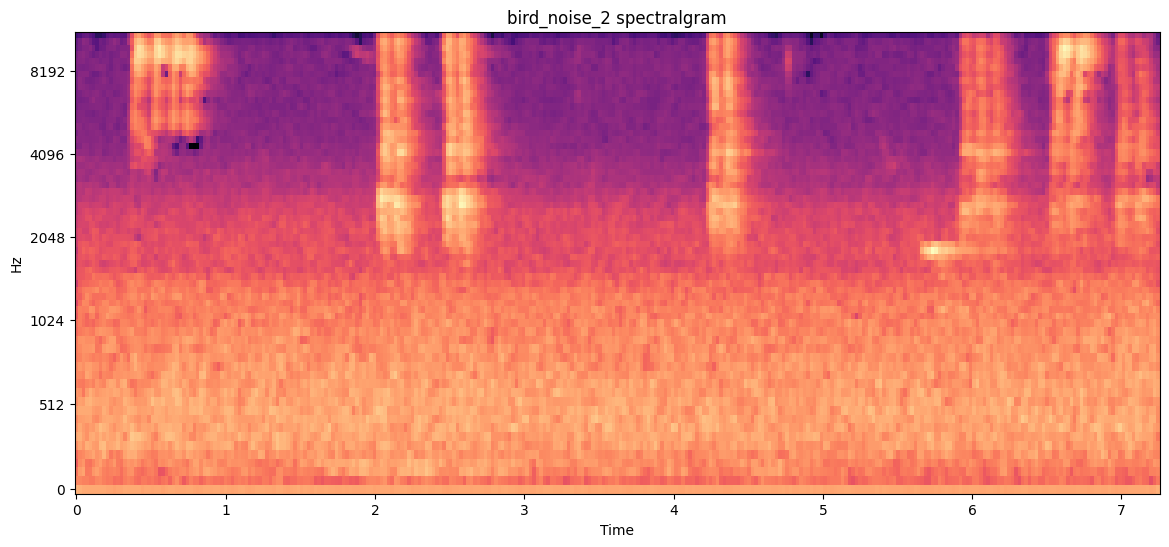

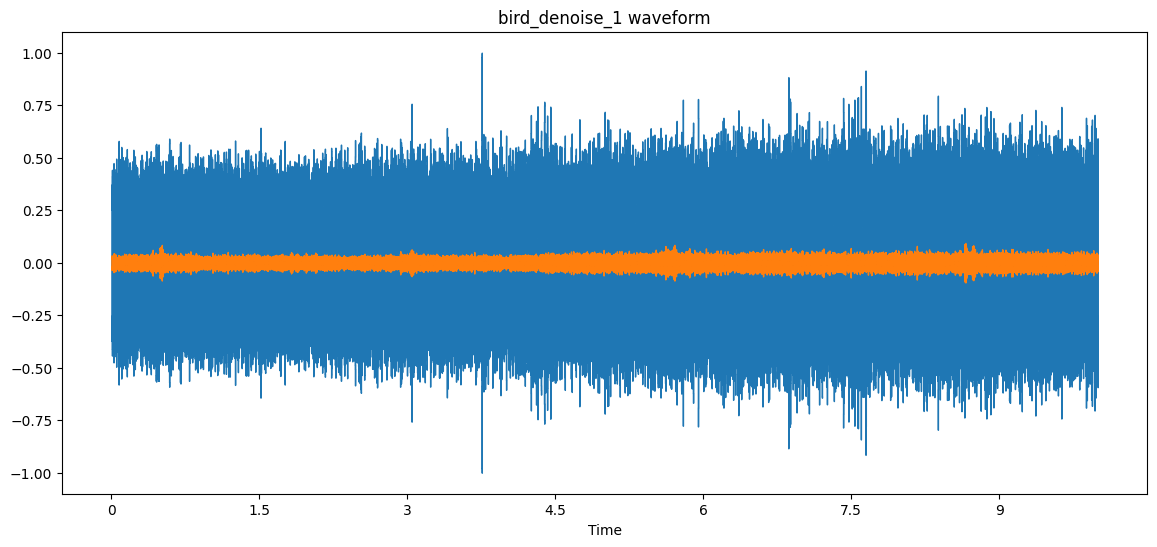

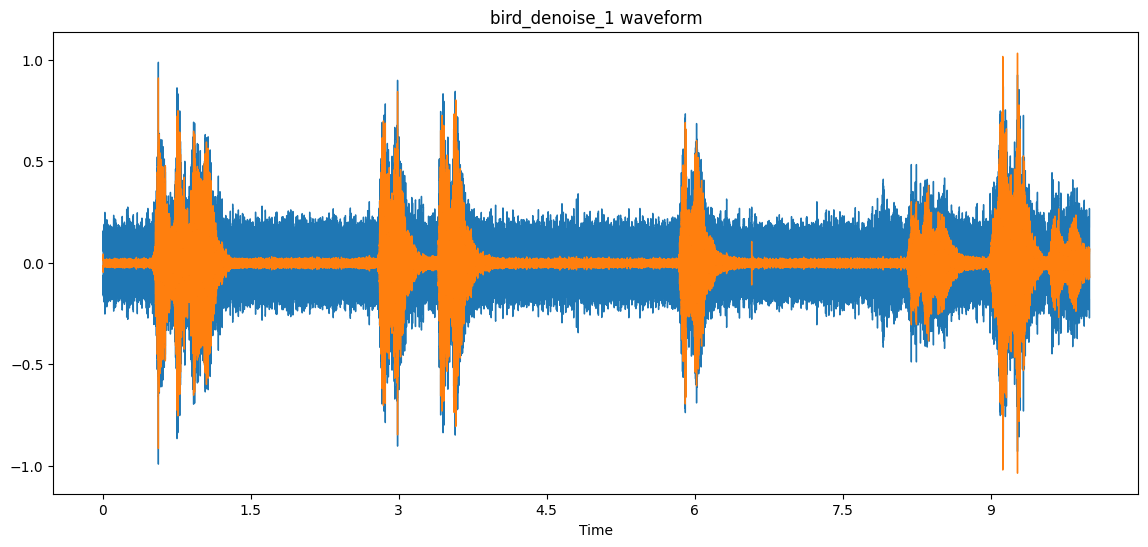

In [ ]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
sr = 16000
e_file1 = 'bird_noise_1.wav'
e_file2 = 'bird_noise_2.wav'

# 10 seconds of each file
y1,sr = librosa.load(e_file1, mono=True, sr=sr, offset=0, duration=10)
y2,sr = librosa.load(e_file2, mono=True, sr=sr, offset=0, duration=10)

#讀入帶噪第一段音訊
plt.figure()
librosa.display.waveshow(y1,sr=sr, x_axis='time');
plt.title('bird_noise_1 waveform')
plt.show()
#讀入帶噪第二段音訊
plt.figure()
librosa.display.waveshow(y2,sr=sr, x_axis='time');
plt.title('bird_noise_2 waveform')
plt.show()

#將第一段音訊轉成頻率域並顯示成頻譜圖
S1 = librosa.feature.melspectrogram(y=y1, sr=sr, n_mels=64)
D1 = librosa.power_to_db(S1, ref=np.max)
plt.figure()
librosa.display.specshow(D1, x_axis='time', y_axis='mel');
plt.title('bird_noise_1 spectralgram')
plt.show()

#將第二段音訊轉成頻率域並顯示成頻譜圖
S2 = librosa.feature.melspectrogram(y=y2, sr=sr, n_mels=64)
D2 = librosa.power_to_db(S2, ref=np.max)
plt.figure()
librosa.display.specshow(D2, x_axis='time', y_axis='mel');
plt.title('bird_noise_2 spectralgram')
plt.show()

#制定一個高通濾波器並將第一段音訊訊號經過濾波
b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
yf1 = signal.filtfilt(b,a,y1)
plt.figure()
librosa.display.waveshow(y1,sr=sr, x_axis='time');
librosa.display.waveshow(yf1,sr=sr, x_axis='time');
plt.title('bird_denoise_1 waveform')
plt.show()

#制定一個高通濾波器並將第二段音訊訊號經過濾波
b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
yf2 = signal.filtfilt(b,a,y2)
plt.figure()
librosa.display.waveshow(y2,sr=sr, x_axis='time');
librosa.display.waveshow(yf2,sr=sr, x_axis='time');
plt.title('bird_denoise_1 waveform')
plt.show()



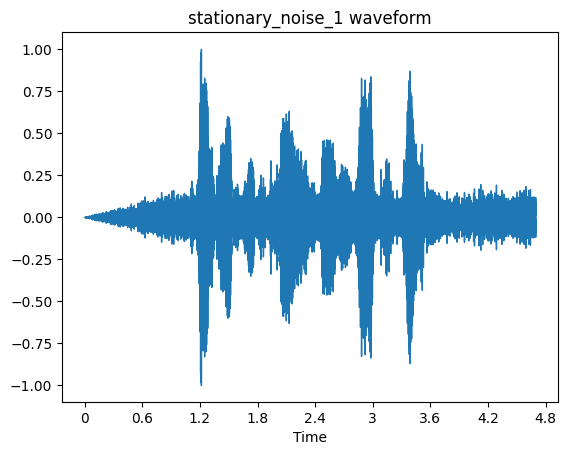

16000


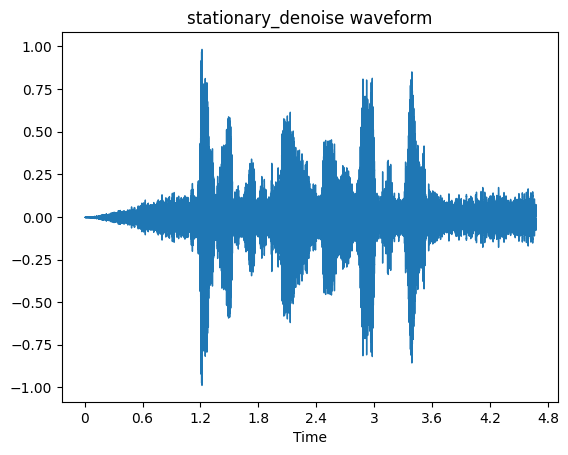

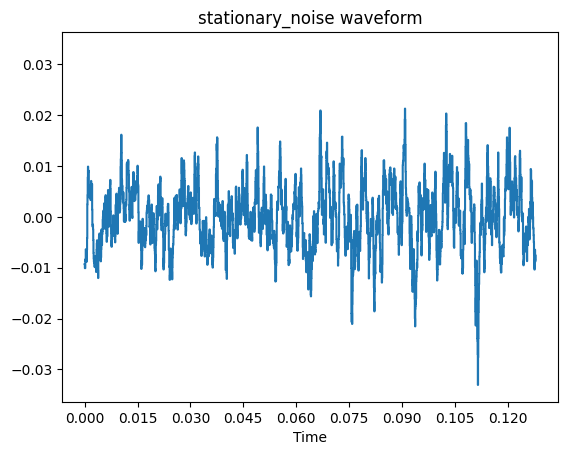

done


In [ ]:
#譜減法
import numpy as np
import librosa
import scipy
from scipy import io
import librosa.display
import matplotlib.pyplot as plt

class SpecSub(object):
  def __init__(self, input_wav):
    self.data, self.fs = librosa.load(input_wav, sr=None, mono=True)
    self.noise_frame = 5  # 使用前n幀作爲噪音估計
    self.frame_duration = 2048/16000  # 一個frame的長度ms 
    self.frame_length = int(self.fs * self.frame_duration) #取得frame的樣本數 (每秒樣本數 * 一個frame的秒數)
    self.fft = 2048  # fft的frame長度

  def main(self):
    noise_data = self.get_noise_data()
    print(self.fs)
    #對語音進行切分frame，對每一個frame都做傅立葉轉換
    dfft = librosa.stft(self.data, n_fft=self.fft)  
    mag = np.abs(dfft)  # get magnitude
    angle = np.angle(dfft)  # get phase
    #噪音也要做傅立葉
    ns = librosa.stft(noise_data, n_fft=self.fft)
    mag_noise = np.abs(ns)
    mns = np.mean(mag_noise, axis=1)  # get mean
    
    #使用帶噪的訊號譜減去估計噪音譜
    sa = mag - mns.reshape((mns.shape[0], 1))  # reshape for broadcast to subtract
    sa = np.maximum(sa, 0)
    sa0 = sa * np.exp(1.0j * angle)  # apply phase information
    
    #對減去噪音譜後的訊號進行傅立葉反轉換得到時域訊號並重組
    y = librosa.istft(sa0)  # back to time domain signal

    scipy.io.wavfile.write('./output.wav', self.fs, (y * 32768).astype(np.int16))  # save signed 16-bit WAV format
    return y, self.fs, noise_data

  #根據語音訊號前幾個frame計算平均噪音譜作為估計噪音譜
  def get_noise_data(self):
    noise_data = self.data[0:self.frame_length]
    for i in range(1, self.noise_frame):
        noise_data = noise_data + self.data[i*self.frame_length:(i+1)*self.frame_length]
    noise_data = noise_data / self.noise_frame

    return noise_data


ss = SpecSub('stationary_noise_1.wav')
plt.figure()
librosa.display.waveshow(ss.data, sr=ss.fs)
plt.title('stationary_noise_1 waveform')
plt.show()
y, fs, noise_data = ss.main()
plt.figure()
librosa.display.waveshow(y, sr=fs)
plt.title('stationary_denoise waveform')
plt.show()
plt.figure()
librosa.display.waveshow(noise_data, sr=fs)
plt.title('stationary_noise waveform')
plt.show()
print('done')

In [4]:
!pip install noisereduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


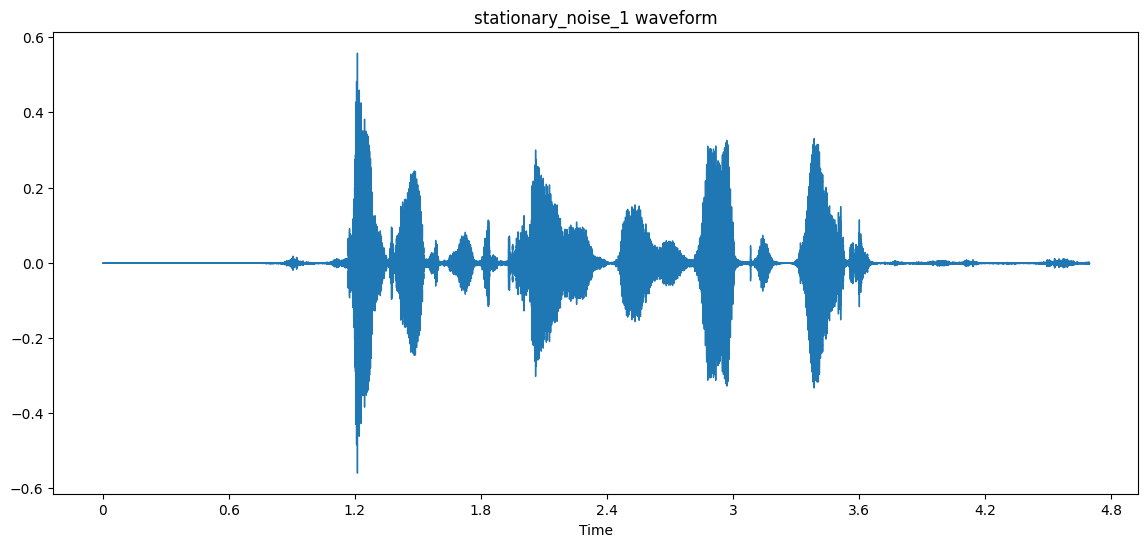

In [ ]:
#noisereduce套件
from scipy.io import wavfile
import librosa
import noisereduce as nr
# load data
data, rate  = librosa.load("stationary_noise_1.wav")
# perform noise reduction
reduced_noise = nr.reduce_noise(y=data, sr=rate)

plt.figure()
librosa.display.waveshow(reduced_noise, sr=rate)
plt.title('stationary_noise_1 waveform')
plt.show()
wavfile.write("stationary_noisereduce.wav", rate, reduced_noise)